**Notebook description:**

In [0]:
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from keras.layers.advanced_activations import LeakyReLU, PReLU

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)


import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split 
from sklearn import metrics  
import pandas as pd

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [0]:
data = pd.read_csv('ks-projects-201801.csv')

In [89]:
data.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


Perform some data cleaning and feature engineering. Create one-hot-encoding for  
string labels.

In [0]:
# number of days between launch data and deadline
def duration_of_project():
    duration = []
    
    for launch, deadline in zip(data['launched'], data['deadline']):
        
        launch = (launch.split())[0]
        launchT = [x.strip() for x in launch.split('-')]
        deadlineT = [x.strip() for x in deadline.split('-')]
    
        year_diff = (int(deadlineT[0]) - int(launchT[0]))*365
        month_diff = (int(deadlineT[1]) - int(launchT[1]))*30
        day_diff = int(deadlineT[2]) - int(launchT[2])
    
        days_offset = year_diff + month_diff + day_diff
        duration.append(days_offset)
        
    data['duration'] = duration

In [91]:
# add column for the duration of the project
duration_of_project()
data.head(10)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,55
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00,35
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00,20
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00,46
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00,35
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00,29


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 16 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
duration            378661 non-null int64
dtypes: float64(5), int64(3), object(8)
memory usage: 46.2+ MB


In [0]:
#getting unique categories in a list
cat = []
for i in data['category']:
    if len(cat) == 0:
        cat.append(i)
    k = 0
    for j in cat:
        if j == i:
            k = 1
            break
    if k==0:
        cat.append(i)
#creating the unique categories successful mean
BackerMean = [0] * 160
GoalMean = [0] * 160

counter = 0
for i in cat:
    count = 0
    total = 0
    for j in data['category']:
        if j==cat[counter]:
            if data['state'][count] == 'successful':
                BackerMean[counter] += data['backers'][count]
                GoalMean[counter] += data['goal'][count]
                total = total + 1
        count = count + 1
    if BackerMean[counter]!= 0:
        BackerMean[counter] = BackerMean[counter]/total
        GoalMean[counter] = GoalMean[counter]/total
    BackerMean[counter] = round(BackerMean[counter])
    GoalMean[counter] = round(GoalMean[counter])
    counter = counter + 1

In [0]:
#Creates a Column stating a binary state on whether or not the project had reached the mean
#of backers in its prospective category
BackerBinary = [0] * 378661
CategoryMean = [0] * 378661
GoalBinary = [0] * 378661
counter = 0
for i in cat:
    count = 0
    for j in data['category']:
        if j == i:
            BackerBinary[count] = data['backers'][count] - BackerMean[counter]
            GoalBinary[count] = data['goal'][count] - GoalMean[counter]
            CategoryMean[count] = BackerMean[counter]
            if BackerBinary[count] < 0:
                BackerBinary[count] = 0
            else:
                BackerBinary[count] = 1
            if GoalBinary[count] > 0:
              GoalBinary[count] = 0
            else:
              GoalBinary[count] = 1
        count = count+1
    counter = counter + 1

In [95]:
data['GoalBinary'] = GoalBinary
data.head(100)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,GoalBinary
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95,58,1
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00,59,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00,44,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00,29,1
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00,55,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00,35,0
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00,20,1
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00,46,0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00,35,0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00,29,0


In [96]:
# convert state to -1, 1 for fail, succeed
data['state'].replace(['canceled'], ['failed'], inplace=True)
data['state'].replace(['failed', 'successful'], [-1, 1], inplace=True)
data.head(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,GoalBinary
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,-1,0,GB,0.0,0.0,1533.95,58,1


In [97]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 17 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
duration            378661 non-null int64
GoalBinary          378661 non-null int64
dtypes: float64(5), int64(4), object(8)
memory usage: 49.1+ MB


In [98]:
data.isnull().sum()
#how do we deal with null values

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
duration               0
GoalBinary             0
dtype: int64

In [99]:
#distribution of categories
print(data['category'].value_counts());
#possible new column (popular category vs unpopular category);

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [0]:
data['state_binary'] = data['state']

In [101]:
data.head(1)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,GoalBinary,state_binary
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,-1,0,GB,0.0,0.0,1533.95,58,1,-1


In [102]:
#translate state to 0 and 1
data['state_binary'].replace([-1, 1], [0, 1], inplace=True)
data.head(1000)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,GoalBinary,state_binary
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,-1,0,GB,0.00,0.00,1533.95,58,1,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,-1,15,US,100.00,2421.00,30000.00,59,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,-1,3,US,220.00,220.00,45000.00,44,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,-1,1,US,1.00,1.00,5000.00,29,1,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,-1,14,US,1283.00,1283.00,19500.00,55,0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,1,224,US,52375.00,52375.00,50000.00,35,0,1
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,1,16,US,1205.00,1205.00,1000.00,20,1,1
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,-1,40,US,453.00,453.00,25000.00,46,0,0
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,-1,58,US,8233.00,8233.00,125000.00,35,0,0
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,-1,43,US,6240.57,6240.57,65000.00,29,0,0


In [103]:
print(data['main_category'].value_counts());

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64


In [104]:
print(data['country'].value_counts());

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64


In [0]:
#boolean for each category. This modified table is stored in "training"
#training=pd.get_dummies(data, columns=["main_category"])
#training.head(1)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


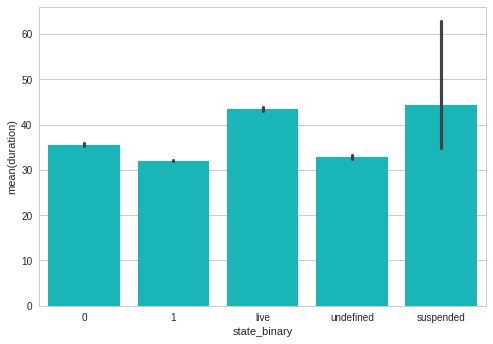

In [106]:
#apperently there are more possible states
sns.barplot('state_binary','duration', data=data, color="darkturquoise")
plt.show()
#Interesting to see is that the duration of unsuccessfull projects is higher. Maybe because successful projects 
#end before their initial end date. The data we got might talk about the actual end and not the initial end date

In [107]:
print(data['state'].value_counts());

-1           236498
1            133956
undefined      3562
live           2799
suspended      1846
Name: state, dtype: int64


SLIM DATA IS THE TABLE THAT I USE FROM THIS POINT ON

In [108]:
#slim data drops "undefined", "live" and "suspended"
slim_data = data.copy()
indexNames = slim_data[ (slim_data['state_binary'] != 1) & (slim_data['state_binary'] != 0) ].index
slim_data.drop(indexNames , inplace=True)
print(slim_data['state_binary'].value_counts());

0    236498
1    133956
Name: state_binary, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


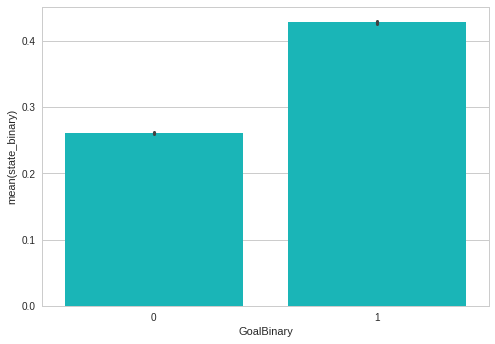

In [109]:
#Average success rate based on setting goal above the average value per category
sns.barplot('GoalBinary','state_binary', data=slim_data, color="darkturquoise")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


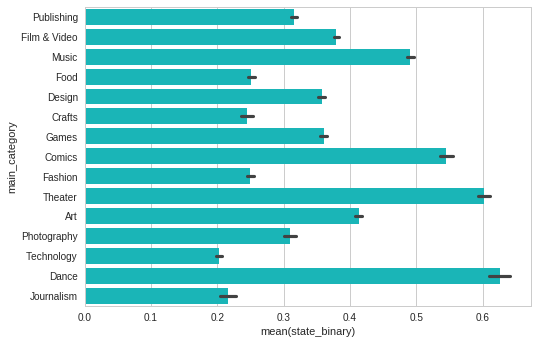

In [110]:
#Average success rate based on category
sns.barplot('state_binary','main_category', data=slim_data, color="darkturquoise")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


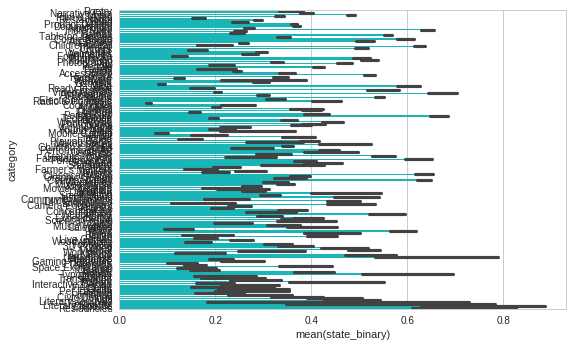

In [111]:
sns.barplot('state_binary','category', data=slim_data, color="darkturquoise")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


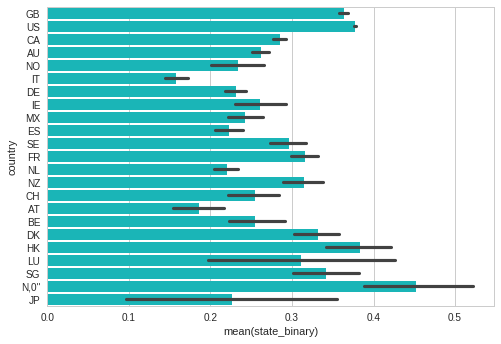

In [112]:
sns.barplot('state_binary','country', data=slim_data, color="darkturquoise")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


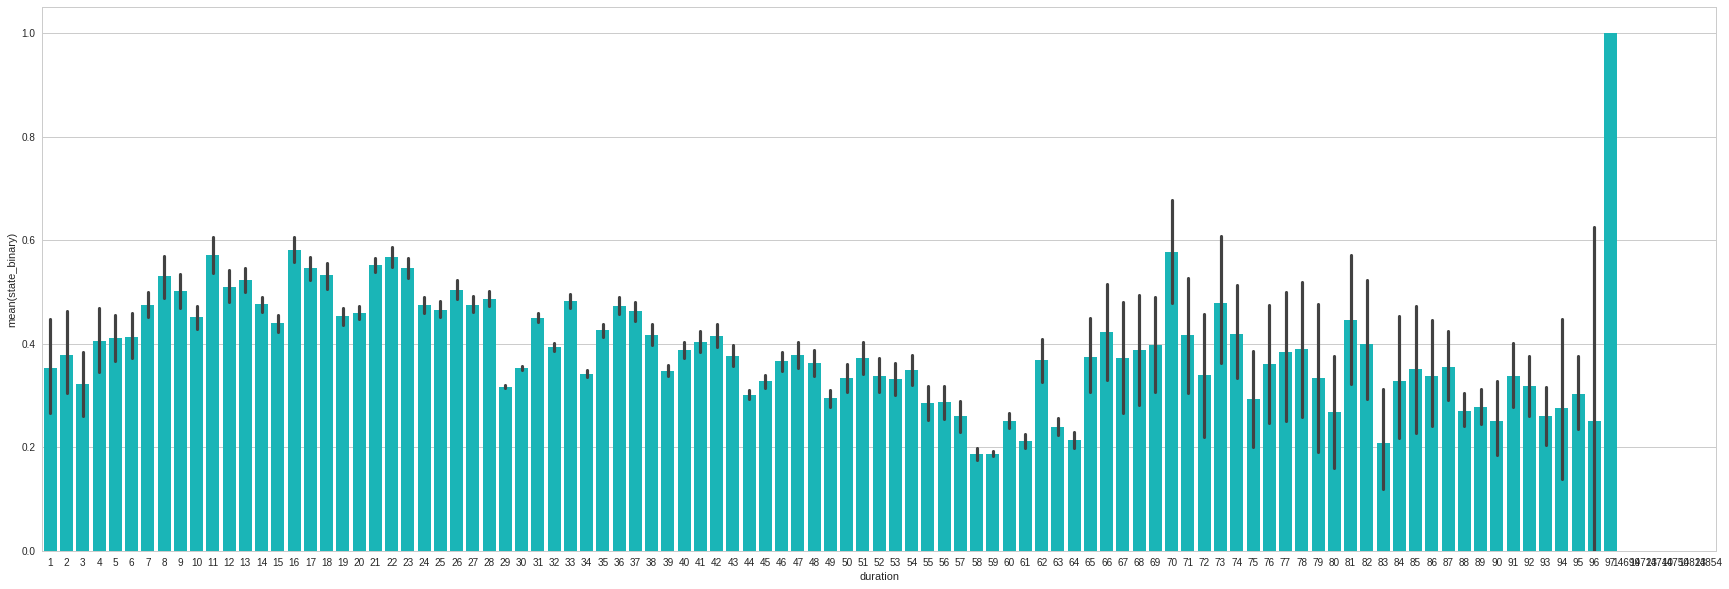

In [113]:
plt.figure(figsize=(30,10))
sns.barplot('duration', 'state_binary',data=slim_data, color="darkturquoise")
plt.show()

In [114]:
data['duration'].describe()

count    378661.000000
mean         34.361608
std          65.879425
min           1.000000
25%          29.000000
50%          30.000000
75%          37.000000
max       16725.000000
Name: duration, dtype: float64

Reducing Variance for the goal column

In [0]:
#All goals below 1000 are updated to 1000
#slim_data.loc[slim_data['goal'] < 1000] = 1000
#slim_data.loc[slim_data['goal'] > 1000000] = 1000000
#slim_data.head(1000)
#slim_data['goal'].describe()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


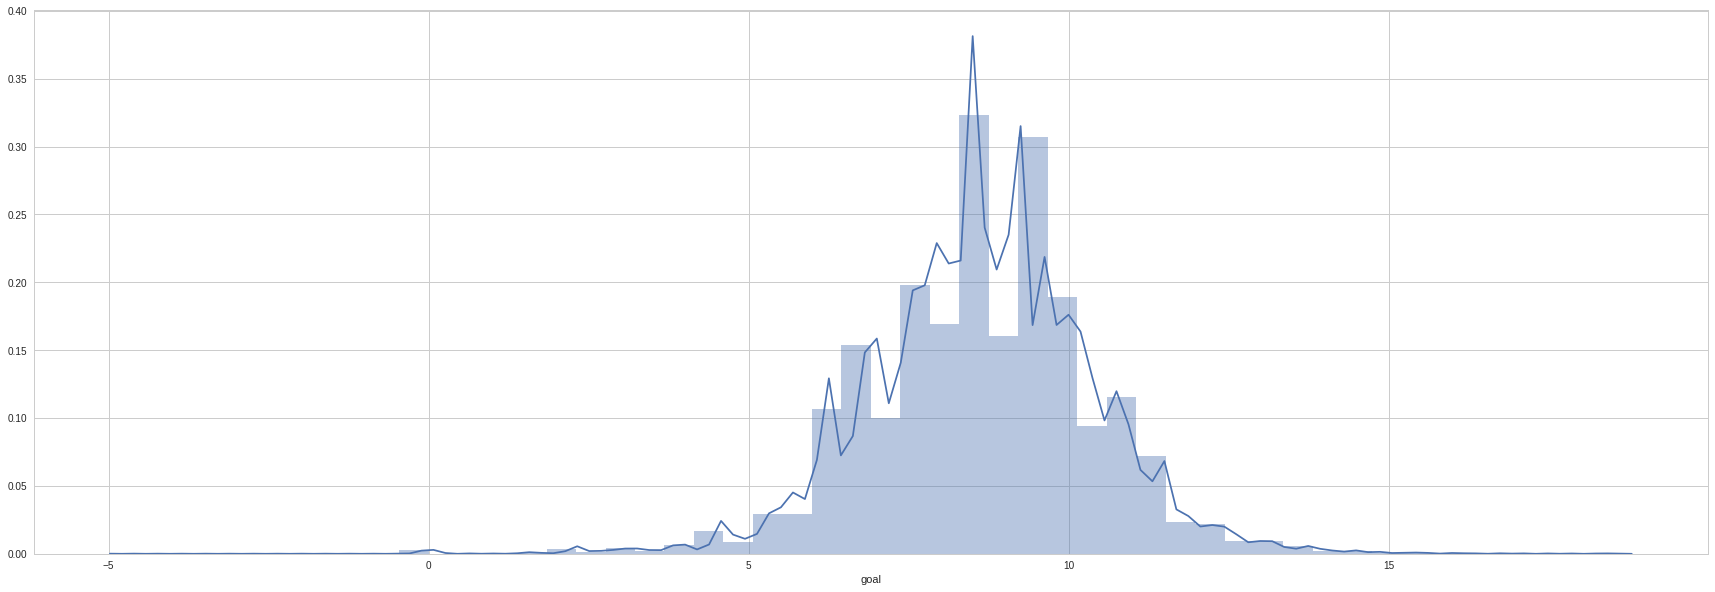

In [116]:
# Goal histogram.
plt.figure(figsize=(30,10))
sns.distplot(np.log(data['goal']))
#plt.yticks(fig.get_yticks(), fig.get_yticks() * 100000)
#plt.ylabel('Distribution [%]', fontsize=16)
#plt.xticks(fig.get_xticks(), fig.get_xticks() * 1)


In [0]:
#Arr = []
#for i in data['currency']:
#    exists = 0
#    if len(Arr) == 0:
#        Arr.append(i)
#    else:
#        for j in Arr:
#            if j == i:
#                exists = 1
#        if exists == 0:
#            Arr.append(i)

**Create one-hot-encodings for columns: category, main-category, currency, country**

In [118]:
#print(slim_data['currency'][0])

unique = []
for curr in slim_data['currency']:
    if curr not in unique:
        print(curr)
        unique.append(curr)

GBP
USD
CAD
AUD
NOK
EUR
MXN
SEK
NZD
CHF
DKK
HKD
SGD
JPY


In [119]:
slim_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,duration,GoalBinary,state_binary
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,-1,0,GB,0.0,0.0,1533.95,58,1,0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,-1,15,US,100.0,2421.0,30000.00,59,0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,-1,3,US,220.0,220.0,45000.00,44,0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,-1,1,US,1.0,1.0,5000.00,29,1,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,-1,14,US,1283.0,1283.0,19500.00,55,0,0


In [0]:
# find length of name
name_length = []
for name in slim_data['name']:
    try:
        name_length.append(len(name))
    except:
        name_length.append(0)
slim_data['name_len'] = name_length

In [121]:
# scale down data columns
sc = MinMaxScaler()

slim_data['fit_goal'] = sc.fit_transform(slim_data[['goal']])
slim_data['fit_name_len'] = sc.fit_transform(slim_data[['name_len']])
slim_data['fit_duration'] = sc.fit_transform(slim_data[['duration']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [122]:
slim_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd pledged,usd_pledged_real,usd_goal_real,duration,GoalBinary,state_binary,name_len,fit_goal,fit_name_len,fit_duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,-1,...,0.0,0.0,1533.95,58,1,0,31,0.000010,0.322917,0.003838
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,-1,...,100.0,2421.0,30000.00,59,0,0,45,0.000300,0.468750,0.003905
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,-1,...,220.0,220.0,45000.00,44,0,0,14,0.000450,0.145833,0.002895
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,-1,...,1.0,1.0,5000.00,29,1,0,49,0.000050,0.510417,0.001885
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,-1,...,1283.0,1283.0,19500.00,55,0,0,58,0.000195,0.604167,0.003636


In [0]:
training=pd.get_dummies(slim_data, columns=["main_category"])
training=pd.get_dummies(training, columns=["category"])
training=pd.get_dummies(training, columns=["country"])
training=pd.get_dummies(training, columns=["currency"])

y = training['state_binary']
X = training.loc[:, 'fit_goal':]
X['GoalBinary'] = slim_data['GoalBinary']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [0]:
#from sklearn.linear_model import LogisticRegression
#logisticRegr = LogisticRegression()
#logisticRegr.fit(X_train, y_train)
#predictions = logisticRegr.predict(X_test)
#score = logisticRegr.score(X_test, y_test)
#print(score)


In [140]:
# build DNN

model = Sequential()

# input layer
model.add(Dense(200, activation='linear', input_dim = 215))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))

# second layer
model.add(Dense(100, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# third layer
model.add(Dense(100, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# fourth layer
model.add(Dense(150, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# fith layer
model.add(Dense(100, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))


# output layer
model.add(Dense(1, activation='sigmoid'))

# compile the model using rmsprop opt and mse loss
model.compile(optimizer = 'adam',  
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y_train, 
                    validation_split = 0.33, 
                    epochs = 50,
                    batch_size = 35)

# Evaluate the model's performance
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Training set accuracy:', train_acc)
print('Test set accuracy:', test_acc)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 198563 samples, validate on 97800 samples
Epoch 1/50
198563/198563 [==============================] - 36s 180us/step - loss: 0.6100 - acc: 0.6689 - val_loss: 0.6000 - val_acc: 0.6807
Epoch 2/50
198563/198563 [==============================] - 36s 183us/step - loss: 0.5998 - acc: 0.6774 - val_loss: 0.6020 - val_acc: 0.6817
Epoch 3/50
198563/198563 [==============================] - 35s 176us/step - loss: 0.5980 - acc: 0.6789 - val_loss: 0.6000 - val_acc: 0.6821
Epoch 4/50
198563/198563 [==============================] - 35s 177us/step - loss: 0.5966 - acc: 0.6792 - val_loss: 0.5996 - val_acc: 0.6793
Epoch 5/50
198563/198563 [==============================] - 36s 179us/step - loss: 0.5953 - acc: 0.6795 - val_loss: 0.5910 - val_acc: 0.6825
Epoch 6/50
198563/198563 [==============================] - 36s 181us/step - loss: 0.5948 - acc: 0.6795 - val_loss: 0.5943 - val_

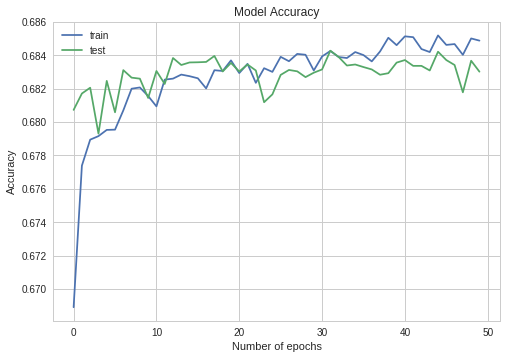

In [141]:
# The history of our accuracy during training.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

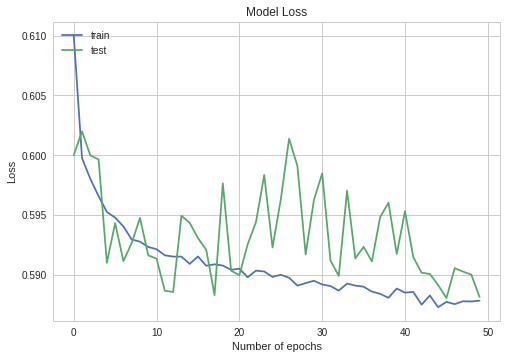

In [142]:
# The history of our cross-entropy loss during training.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()